### Imports

In [3]:
import numpy as np
import torch
from utils.preprocess import getData
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.DoubleTensor)

from networks.rnn import *
from utils.validate import validate
from utils.test_accuracy import test

### Functions to train, other utilities

In [4]:
def get_idxs(in_array, to_find):
    """Utility function for finding the positions of observations of one array in another an array.
    Args:
        in_array (array): Array in which to locate elements of to_find
        to_find (array): Array of elements to locate in in_array
    Returns:
        TYPE: Indices of all elements of to_find in in_array
    """
    targets = ([np.where(in_array == x) for x in to_find])
    return np.squeeze(np.concatenate(targets, axis=1))

def _LSTM_(input_dim, hidden_dim, layer_dim, output_dim, criterion, num_epochs):
    """
    Here you can switch between LSTMModel and LSTM_CNN.
    Just note that LSTMModel has different input size so don't forget to check dimensions
    """

    #model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
    
    model = LSTM_CNN(input_dim, hidden_dim, layer_dim, output_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    print(model)
    
    stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
    }
    for epoch in range(num_epochs): # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0.0
        total = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #inputs = inputs.float()
            #labels = labels.float()
      
            outputs = model.forward(inputs) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
            
            
            
            # obtain the loss function
            
            loss = criterion(outputs.double(), labels.double())
    
            loss.backward() #calculates the loss of the loss function
    
            optimizer.step() #improve from loss, i.e backprop
            
            # accumulate loss
            running_loss += loss.item()
            
            # Make prediction for batch
            _, predicted = outputs.max(1)
            
            # Store accuracy for batch
            # WE convert back from one-hot to integer for checking accuracy
            
            #print(predicted.shape)
            #print(torch.argmax(labels, dim=1).shape)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
            
        # Store accuracy,loss for epoch
        train_loss=running_loss/len(trainloader)
        train_accuracy=100.*correct/total
        
        # At the end of each epoch, calculate validation accuracy
        
        # Set the network in eval mode since we're not training here
        model.eval()
        
         # Turn gradient computation off
        with torch.no_grad():
            val_accuracy, val_loss = validate(model, valloader, criterion)
        
        # Set the network back in training mode
        model.train()
        
        stats['train_accuracies'].append(train_accuracy)
        stats['train_losses'].append(train_loss)
        stats['val_accuracies'].append(val_accuracy)
        stats['val_losses'].append(val_loss)
        
        
        # Display results
        print(f'Epoch: {epoch}')
        print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
        print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')
        
    
    return stats

### Hyperparamaters

In [5]:
batch_size=10
num_epochs = 20 
learning_rate = 0.01 #0.001 lr
hidden_dim = 4 #number of features in hidden state
layer_dim = 1 #number of stacked lstm layers

### Load, Preprocess Data

In [6]:
X_train, y_train, X_valid, y_valid, X_test, y_test, person_train, person_valid, person_test, original = getData(lib='torch')

# Get data for specific subjects

idx_train = get_idxs(person_train, np.array([1]))[0]
idx_test = get_idxs(person_test, np.array([1]))[0]
X_train = X_train[idx_train,...]
X_test = X_test[idx_test,...]
y_train = y_train[idx_train,...]
y_test = y_test[idx_test,...]

# Reshape the input
#LSTM: we need (N, 250, 22) #(N,L,H) input of batch_dim x seq_dim x feature_dim
"""
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[2], X_train.shape[1]))
X_valid= torch.reshape(X_valid, (X_valid.shape[0], X_valid.shape[2], X_valid.shape[1]))
X_test= torch.reshape(X_test, (X_test.shape[0], X_test.shape[2], X_test.shape[1]))
"""
#CNN_LSTM: 
X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid= torch.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test= torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [7]:
print(X_train.shape)

torch.Size([787, 22, 250])


### Setup DataLoaders

In [8]:
trainset = torch.utils.data.TensorDataset(X_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# Shuffle is set to false for validation and test sets since no training is done on them, all we do is evaluate.
valset =  torch.utils.data.TensorDataset(X_valid, y_valid)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=0)

### Train the Model

In [9]:
feature_dim = X_train.shape[2]#(X_train.shape[1],X_train.shape[2]) #number of features
seq_dim = X_train.shape[1]


input_dim = 22
output_dim = 4 #number of output classes
seq_dim = 250  # Number of steps to unroll

criterion = torch.nn.MSELoss()#torch.nn.L1Loss()

stats = _LSTM_(input_dim, hidden_dim, layer_dim, output_dim, criterion, num_epochs)

LSTM_CNN(
  (conv1): Conv1d(22, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (lstm1): LSTM(238, 4)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
)


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 0
	 -- Train Loss: 0.3024097437995131 | Train Accuracy: 26.810673443456164
	 -- Val Loss: 0.2575088570424097 | Val Accuracy: 25.666666666666668
Epoch: 1
	 -- Train Loss: 0.22446616858032165 | Train Accuracy: 26.55654383735705
	 -- Val Loss: 0.21224591265574588 | Val Accuracy: 26.6
Epoch: 2
	 -- Train Loss: 0.1963882557492705 | Train Accuracy: 26.810673443456164
	 -- Val Loss: 0.19766637113434876 | Val Accuracy: 26.533333333333335
Epoch: 3
	 -- Train Loss: 0.1891703142664271 | Train Accuracy: 28.970775095298603
	 -- Val Loss: 0.19300372519999107 | Val Accuracy: 28.466666666666665
Epoch: 4
	 -- Train Loss: 0.18681878228129262 | Train Accuracy: 34.30749682337992
	 -- Val Loss: 0.19217295378780008 | Val Accuracy: 29.133333333333333
Epoch: 5
	 -- Train Loss: 0.18541820142404788 | Train Accuracy: 33.29097839898348
	 -- Val Loss: 0.19190508507323586 | Val Accuracy: 29.0
Epoch: 6
	 -- Train Loss: 0.18307917383725272 | Train Accuracy: 35.45108005082592
	 -- Val Loss: 0.1925542885275882 |

### Store results

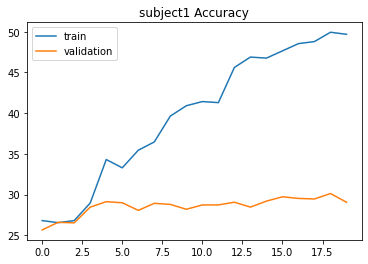

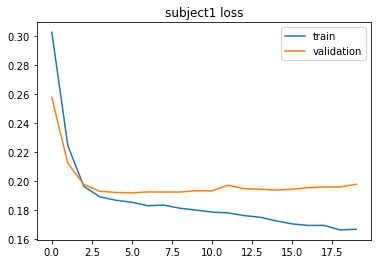

In [13]:
acc_name = 'figures/1_lstm_cnn_acc_hid_'+str(hidden_dim)+'_lay_'+str(layer_dim)+'_loss_'+'MSE'+'_lr_'+str(learning_rate)+'_batch_'+str(batch_size)+'.png'

plt.figure()
plt.plot(stats['train_accuracies'])
plt.plot(stats['val_accuracies'])

plt.legend(['train','validation'])
plt.title('subject1 Accuracy')

plt.savefig(acc_name)

loss_name = 'figures/1_lstm_cnn_loss_hid_'+str(hidden_dim)+'_lay_'+str(layer_dim)+'_loss_'+'MSE'+'_lr_'+str(learning_rate)+'_batch_'+str(batch_size)+'.png'
plt.figure()
plt.plot(stats['train_losses'])
plt.plot(stats['val_losses'])

plt.legend(['train','validation'])
plt.title('subject1 loss')

plt.savefig(loss_name)

#don't forget to edit figure names, here it's subject specific